TODO:

Comparison with incremental - should get same plot with fixed seeds

UCB derivation + experiment

Application to Opengym env (Contextual bandits)

Application to netpipe experiment

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [241]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import pandas as pd
import gym

import matplotlib.pylab as plt

# Introduction to the OpenAI gym

In [3]:
env = gym.make('CartPole-v1')

In [4]:
state = env.reset()
print(f'Current State = {state}')

Current State = [ 0.0250601   0.00374017 -0.04489948  0.03326008]


In [5]:
env.render()

True

In [6]:
print(f'Action Space = {env.action_space}')

Action Space = Discrete(2)


In [7]:
print(f'Observation Space = {env.observation_space}')

Observation Space = Box(4,)


In [8]:
action = env.action_space.sample()
print(f'Randomly chosen action = {action}')

Randomly chosen action = 0


In [9]:
state, reward, done, info = env.step(action)

In [10]:
print(f'Action taken = {action}')
print(f'New State = {state}')
print(f'Reward received = {reward}')
print(f'Simulation done? = {done}')
print(f'Auxiliary info = {info}')

Action taken = 0
New State = [ 0.02513491 -0.1907101  -0.04423427  0.31144553]
Reward received = 1.0
Simulation done? = False
Auxiliary info = {}


In [11]:
#run N steps
env = gym.make('BipedalWalker-v2')

state = env.reset()
N = 1000 #run 1000 time-steps
for t in range(N):
    env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    
    if done:
        state = env.reset()        

KeyboardInterrupt: 

In [12]:
env.close()

ValueError: invalid literal for int() with base 10: ''

## What other environments are possible?

https://gym.openai.com/envs/#classic_control

# Multi-armed Bandits

The material below is mostly based on the book by Sutton and Barto. I have tried to keep the notation consistent with the book and also inserted a few exercises from the book below.

### Comparison to Supervised Model

In a supervised model, the model tells us **what action to take**. This is often called ***instruction***. The action you actually take might be different.

In a reinforcement learning setup, the model tells us **how good the action is**. This is often called ***evaluation***.

Multi-armed bandits let us study a simplified version of the reinforcement learning problem. We will see both how to evaluate an action as well as how to use the evaluative part to take ("instruct") an action.

### Core Idea

Suppose you are at a slot machine with k slots. So you have k levers that can be pulled. On pulling each lever, you get a reward (some money) according to a stationary probability distribution that depends on the lever. Stationary means that the distribution for any lever doesn't change with time. For example lever 1 might have a normal distribution with mean \\$100 and standard deviation $10 (if you get a negative number, you have to pay that much to the casino). 

This might sound like an artificial problem but applies to any setup where there are k discrete options with stationary distributions.

The catch is that you do not know the distributions in advance. If you did and you had enough time, you would just keep pulling on the lever with the highest mean (even if the standard deviation is high) and in the long run, i.e. in $T$ time-steps, you'll get a total reward of $T * \text{mean}$.

**Mathematical Aside**: 

If you are given N independent and identically distributed random variables (outcomes of a probabilistic experiments):

$$X_1, X_2, \ldots, X_N$$

each with mean = $\mu$ and standard deviation = $\sigma$ (variance = $\sigma^2$ by definition).

then we are interested in looking at the total (each $X$ is a pull of the lever and there are $N$ pulls):

$$Y = X_1 + X_2 + \ldots + X_N$$

We have:

$$\text{mean of Y} = N\mu$$

$$\text{variance of Y} = N\sigma^2 \rightarrow \text{standard deviation of Y} = \sqrt{N}\sigma$$ 

So, after $N$ pulls, you'll get an average reward of $N\mu$ which is good because the higher the $\mu$, the more reward you'll get. Also, you might think that the "error" (standard deviation) of $Y$ also increases with $N$ which is true but the relevant quantity is the relative error:

$$\frac{\text{standard deviation of Y}}{\text{mean of Y}} = \frac{\sqrt{N} \sigma}{N \mu} \rightarrow_{N\rightarrow\infty} 0$$

In other words, your total reward goes up with the number of steps ($N$) and the relative deviation in your total reward goes to 0.

**End of Mathematical Aside**:

You have a choice of k actions - which lever to pull. Each action has a mean reward which is called the **value of the action**. Let's define a few quantities:

$$A_t = \text{action taken at time t}$$

$$R_t = \text{reward received at time t}$$

Note that the reward at time t is a number drawn from the stationary distribution for the lever pulled at time t.

So, another way of writing the value of an action (or a lever in our case) is:

$$q_*(a) = \mathbb{E}[R_t | A_t = a]$$

$\mathbb{E}$ means expected value or the mean of the variable $R_t$. The notation $[R_t | A_t = a]$ should be read as "the reward at time t **given** that the action at time t was a particular action a". In other words, $q_{*}(a)$ is the mean or expected reward for the action a. It is the unknown quantity that we would like to learn because if we did, then we could always take the action (i.e. pull the lever) with the highest $q_{*}(a)$.

The real challenge of course, is that we don't know anything about the values of the levers when we start the game. More formally, the challenge is:

**Given T time-steps, get the maximum money possible from the slot machine**

So our task is to try estimating the value of each action where there are k actions i.e. the act of pulling each of one of the k levers. These value estimates will change in time so let's denote them by

$$Q_t(a) = \text{estimate of the value of action a at time t}$$

Hopefully over time, our estimates will get better and we'll converge to $q_{*}(a)$ i.e. with time:

$$Q_t(a) \rightarrow_{t\rightarrow\infty} q_*(a)$$

Some more definitions:

Suppose at any given time t, you look at your estimates of the values, Q_t(a) and pick the action a with the highest possible Q_t(a). This would be called a ***greedy action***. Note that the greedy action isn't necessarily globally the best option because we don't have access to the true value, $q_*(a)$. The process of always using greedy actions is called ***exploitation***. On the other hand, if you don't pick the greedy action, the process is called ***exploration***.

In reinforcement learning, there's always a tradeoff between exploration and exploitation. In our particular case, you could try actions randomly for 10 steps and then always pick the greedy action. This would give you pretty bad results for say k = 10 since you either have no estimate or bad estimates for the actions. In the short-term it might sound desirable but in the long-term, you almost certainly are picking bad actions. Or you could be more patient and wait for 100 steps, get better estimates of the values and then pick the greedy actions. In this case, you spent more time exploring and potentially getting lower rewards for the first 100 steps but then get much higher rewards with lesser uncertainty.



### Estimating Action Values

So our central problem is to estimate the value of each action in as few time steps as possible. This would then let us use the greedy action and maximize our rewards.

There's an obvious way to estimate these values:

$$Q_t(a) \equiv \frac{\text{sum of rewards when action a is taken till time t}}{\text{number of times action a is taken till time t}} = \frac{\Sigma_{i=1}^{t-1}R_i \mathbb{1}_{A_i=a}}{\Sigma_{i=1}^{t-1} \mathbb{1}_{A_i=a}}$$

The second equation is a more formal way of writing the average reward when action a is taken. $\mathbb{1}_{A_i=a}$ is a so-called indicator variables such that:

$$\mathbb{1}_{A_i=a} = \begin{cases}
1 \text{ if } A_i = a \\
0 \text{ if } A_i \neq a \\
\end{cases}$$

In other words, we are just keeping a running average of rewards for each action in a table. What can go wrong? At a given time t, there might be actions that we never got around to taking. Then we should set $Q_t(a)$ for such actions to be a default low value, say 0. With enough time, our estimates will keep getting better as we take each action more often and in the long-run, $Q_t(a) \rightarrow q_*(a)$.

### Taking actions 

Once we have our estimates, $Q_t(a)$, what should we do? As mentioned before, one could take the greedy action:

$$A_t = arg\,max_{a} Q_t(a)$$

What can go wrong with this rule? If done too soon ($t$ is small enough to not get good estimates for the values, $Q_t(a)$), then we could get stuck just picking a few actions and getting more precise estimates for those actions but completely ignoring other actions that might lead to more reward in the long-run. The extreme case is where the best action, the one with the highest $q_*(a)$ was never sampled and has $Q_t(a) = 0$ (our default value) which means it'll never get picked greedily and will never get its value updated.

There's a simple solution to this problem. We use the so-called $\epsilon\text{-greedy}$ method. $\epsilon$ is used as a proxy for a small number greater than 0 in mathematics. What this method does is to pick a small number, say $\epsilon = 10^-2$ and with probability $\epsilon$, pick a random action and with probability $1-\epsilon$, pick the greedy action according to the value estimates $Q_t(a)$.

Why does this help? Because just by chance we'll randomly take other actions and update their value estimates $Q_t(a)$ which gives every action a chance to get sampled.

### Exercise 2.1

In $\epsilon\text{-greedy}$ action selection, for the case of two actions and $\epsilon=0.5$, what is the probability that the greedy action is selected?

There are two ways to get to the greedy action:

1. Pick greedy action with probability $1-\epsilon$.

2. With probability $\epsilon$, pick a random action. The probability of picking the greedy action is $\frac{1}{k}$ where $k$ = number of actions.

So, total probability of picking the greedy action is:

$$1-\epsilon + \epsilon \frac{1}{k} = 1 - \epsilon(1 - \frac{1}{k})$$

For $\epsilon = 0.5$ and $k = 2$, we get:

$$1 - 0.5*(1-\frac{1}{2}) = \frac{3}{4}$$

### Sutton-Barto - 2.3 The 10-armed Testbed (Simulations)

<img src='media/SuttonBartoBandits.png'>

In [200]:
def generate_instance(seed = None):
    '''Generate an instance with 10 arms 
    where each arms has rewards distributed according
    to a normal distribution with some mean and variance=1.
    The mean of each arm is also chosen according to a normal
    distribution which itself has a mean=0.0 and variance=1.
    
    with means selected
    also according to a normal distribution between 0 and 1 
    and variance = 1
    '''
    if seed is not None:
        np.random.seed(seed)
    
    #means = np.random.uniform(low=0.0, high=1.0, size=(10))
    
    means = np.random.normal(loc=0.0, scale=1.0, size=(10))
    variances = np.ones_like(means)
    
    return means, variances

def run_experiment(means, variances, time_steps=1000, epsilon=1e-2, seed=None):
    '''Given an instance of the k-armed bandit problem,
    run time_steps time steps with epsilon-greedy actions.
    Update Q (value of an action) at each time-step
    '''
    #seed=None -> change state
    np.random.seed(seed)
    
    K = len(means) #number of arms
    Q_estimates = np.zeros_like(means) #same shape as means or number of arms
    sums = np.zeros_like(means)
    counters = np.zeros_like(means)
    
    total_reward = 0
    average_reward_timeseries = []
    
    for t in range(time_steps):
        if np.random.random() < epsilon:
            #random selection
            arm_selected = np.random.randint(K)
        
        else:
            #greedy selection
            arm_selected = np.argmax(Q_estimates)
            
        m = means[arm_selected]
        var = variances[arm_selected]
        
        reward = np.random.normal(loc=m, scale=var) #rewards are normally distributed
        total_reward += reward
        average_reward_timeseries.append(total_reward / (t+1))
        
        #update Q
        sums[arm_selected] += reward
        counters[arm_selected] += 1
        
        Q_estimates[arm_selected] = sums[arm_selected] / counters[arm_selected]

    assert(np.allclose(np.sum(sums), total_reward, rtol=1e-5)) #comparison within tolerance rtol
    
    return total_reward, average_reward_timeseries, Q_estimates, means, variances, sums, counters

In [201]:
means, variances = generate_instance(seed=0)
total_reward, avg_reward_ts, Q_estimates, means, variances, sums, counters = run_experiment(means, 
                                                                                            variances, 
                                                                                            time_steps=1000, 
                                                                                            epsilon=1e-2)

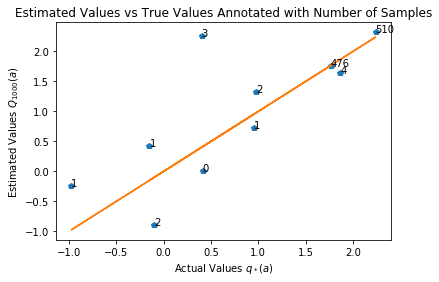

In [202]:
fig, ax = plt.subplots()

ax.plot(means, Q_estimates, 'p')
ax.plot(means, means)
plt.xlabel('Actual Values $q_*(a)$')
plt.ylabel('Estimated Values $Q_{1000}(a)$')
plt.title("Estimated Values vs True Values Annotated with Number of Samples")

for index, number in enumerate(counters):        
        ax.annotate(int(number), (means[index], Q_estimates[index]))

#### Experiment 1: Effect of $\epsilon$

In [203]:
#Let's run with epsilon 1e-2
means, variances = generate_instance(seed=0)
total_reward, _, Q_estimates, means, variances, sums, counters = run_experiment(means, 
                                                                                variances, 
                                                                                time_steps=1000, 
                                                                                epsilon=1e-2,
                                                                                seed=0)

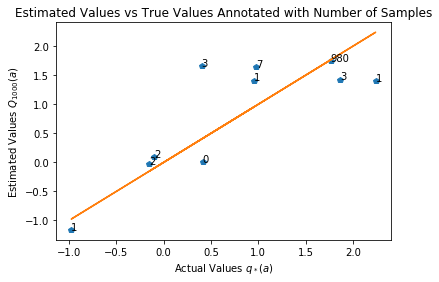

In [204]:
fig, ax = plt.subplots()

ax.plot(means, Q_estimates, 'p')
ax.plot(means, means)
plt.xlabel('Actual Values $q_*(a)$')
plt.ylabel('Estimated Values $Q_{1000}(a)$')
plt.title("Estimated Values vs True Values Annotated with Number of Samples")

for index, number in enumerate(counters):        
        ax.annotate(int(number), (means[index], Q_estimates[index]))

In the plot above, the x-axis is the actual value of each action (generated uniformly between 0-1) while the y-value is the estimated value of each action which is a running average of the actions we took during our experiment. The diagonal line is the line $y = x$ where we expect all the points to line i.e. $Q_t(a) = q_*(a)$.

While a few points are close to the line, there are many that are pretty far away. We don't have good value estimates for those points. Why does that happen? Each point is annotated with the number of times we visited that lever/action during the experiment. As expected, a few actions were taken multiple times leading to good estimates of their values but others were barely visited (or not visited at all) which leads to bad estimates.

This suggests that if we were to increase $\epsilon$, then we'll randomly sample other states more often leading to better value estimates. Let's try this by increasing $\epsilon$ by a factor of 10.

In [205]:
#Let's run with epsilon 1e-1
means, variances = generate_instance(seed=0)
total_reward, _, Q_estimates, means, variances, sums, counters = run_experiment(means, 
                                                                                variances, 
                                                                                time_steps=1000, 
                                                                                epsilon=1e-1,
                                                                                seed=0)

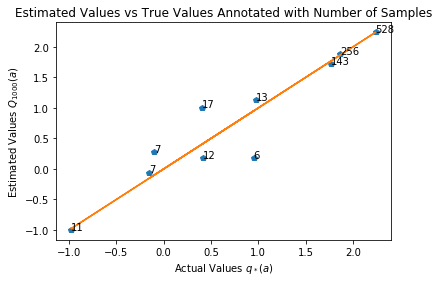

In [206]:
fig, ax = plt.subplots()

ax.plot(means, Q_estimates, 'p')
ax.plot(means, means)
plt.xlabel('Actual Values $q_*(a)$')
plt.ylabel('Estimated Values $Q_{1000}(a)$')
plt.title("Estimated Values vs True Values Annotated with Number of Samples")

for index, number in enumerate(counters):        
        ax.annotate(int(number), (means[index], Q_estimates[index]))

Now we have many more points near the diagonal. We still have a couple of points which weren't visited much but the situation is much better than the previous case with $\epsilon = 1e-2$.

#### Experiment 2: Average reward vs Number of Steps for Epsilon = (0.0, 0.1, 0.01)

In [207]:
#run each particular instance with particular means a total of 2000 times
N_experiments = 2000
time_steps = 1000

In [208]:
# Epsilon = 0.0
def get_avg_rewards(epsilon):
    avg_rewards = np.zeros((N_experiments, time_steps))
    for exp in range(N_experiments):
        means, variances = generate_instance(seed=exp)
        _, avg_reward_ts, _, _, _, _, _ = run_experiment(means,
                                                         variances, 
                                                         time_steps=time_steps, 
                                                         epsilon=epsilon)
        avg_rewards[exp, :] = avg_reward_ts
    
    return avg_rewards

In [209]:
avg_rewards_eps0 = get_avg_rewards(0.0)
avg_rewards_epsd1 = get_avg_rewards(1e-1)
avg_rewards_epsdd1 = get_avg_rewards(1e-2)

Text(0, 0.5, 'Average reward at time t = Total reward / t')

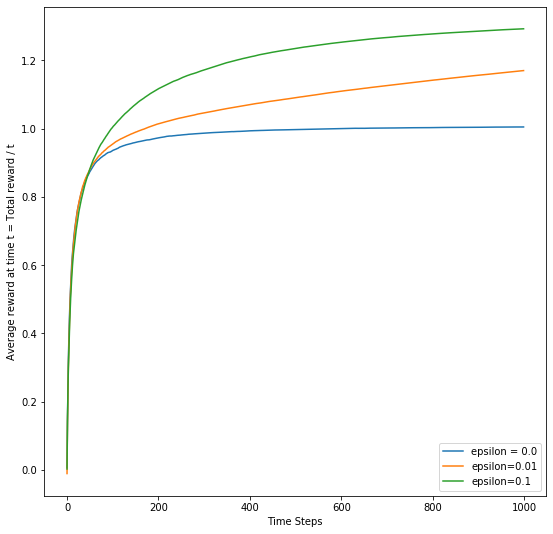

In [210]:
plt.figure(figsize=(9,9))
plt.plot(avg_rewards_eps0.mean(axis=0), label='epsilon = 0.0')
plt.plot(avg_rewards_epsdd1.mean(axis=0), label='epsilon=0.01')
plt.plot(avg_rewards_epsd1.mean(axis=0), label='epsilon=0.1')
plt.legend(loc=4)
plt.xlabel('Time Steps')
plt.ylabel('Average reward at time t = Total reward / t')

Let's understand the plot above. The x-axis is time with a total of 1000 time-steps for each trial. The y-axis is the average reward per time-step as a function of time. In other words, at time t, we take the total reward accumulated till then, and divide by the time elapsed. This is a measure of the efficiency of our learning mechanism. If we learn which lever has the highest reward rapidly, we can keep pulling it thus increasing our average reward per unit time.

One problem with making a plot like this is that we might get biased results if we choose just one set of levers and rewards (the parameters of the distributions). To account for this, we generate 2000 experiments, each with 10 levers but with different parameters and run our experiment for each one. For each experiment, we get a time-series of average reward as a function of time. We average these across the 2000 experiments to get the value plotted on the y-axis. This way we can be pretty certain that we are looking at general trends and not something particular to one set of lever reward values.

$\epsilon = 0$: This is the $\color{blue}{\text{blue}}$ line. Since $\epsilon = 0$, at every time-step, we greedily pick the best action or lever i.e. the one with the highest $Q_t(a)$. 

**Note**: Since we start out with $Q_0(a) = 0,  \forall a$, np.argmax will pick index = 0 as the first action and update its value, $Q_t(a = 0)$. If this value is positive, action = 0 will be picked again while if it's negative, index = 1 will be picked since $Q_1(a=1) = 0$.

In this regime, we are purely exploiting the knowledge we have and very quickly we saturate to an average reward which indicates we stopped learning anything more about our actions.

$\epsilon = 0.01$: This is the $\color{orange}{\text{orange}}$ line. In this regime, the average reward keeps climbing because with a small probability ($ = \epsilon$), we pick a random action that lets us stumble upon more information about the non-greedy actions and get better estimates of their reward. This suggests that we should increase $\epsilon$ to gather information about other actions more quickly.

$\epsilon = 0.1$: This is the $\color{green}{\text{green}}$ line. This is exactly what we expected. With a larger $\epsilon$, we pick a non-greedy action more frequently and estimate its value with more samples and less uncertainty. This leads to a much faster route to finding the most optimal action i.e. the one with the highest $q_*(a)$.


#### Experiment 3: Percentage of time optimal action was picked

### Sutton-Barto - 2.4 Incremental Computation

In the function run_experiments above, we keep track of two lists: sums and counters, each of which is indexed by the action to keep track of the average reward value when action $i$ was taken. In other words:

$$Q_t(a) = \frac{\text{sums}[a]}{\text{counters}[a]}$$

and $\text{sums[a]}, \text{counters}[a]$ is updated each time we take action $a$.

In more complicated problems, the action space can be enormous. It pays to compress this computation to just a single array. Can we do that? Yes!

Suppose, we have an estimate of an action's value at time t:

$$Q_t(a) = \frac{R_1 + R_2 + \ldots + R_{t-1}}{t-1}$$

This is a bit sloppy since it implies the first $t-1$ steps all took the same action. This is only for notational convenience.)

Suppose, we take the same action $a$ at time-step $t$ and get a reward $R_t$. Then,

$$Q_{t+1}(a) = \frac{R_1 + R_2 + \ldots + R_{t-1} + R_t}{t}$$ 

by definition. We'll try writing this in terms of $Q_t(a)$.

\begin{equation}
\begin{split}
Q_{t+1}(a) &= \frac{R_1 + R_2 + \ldots + R_{t-1}}{t} + \frac{R_t}{t} \\
& = \frac{R_1 + R_2 + \ldots + R_{t-1}}{t-1} \frac{t-1}{t} + \frac{R_t}{t} \\
& = Q_t(a) \frac{t-1}{t} + \frac{R_t}{t} \\ 
& = Q_t(a) (1 - \frac{1}{t}) + \frac{R_t}{t} \\
& = Q_t(a) + \frac{1}{t} [R_t - Q_t(a)] \\
\end{split}
\end{equation}

This is of a form:

$$Q_{\text{new}} = Q_{\text{old}} + (\text{update weight}) \text{ update}$$

where $\text{update weight} = \frac{1}{t}$ and $\text{update} = R_t - Q_t(a)$.

If you have seen gradient descent, this should look oddly familiar. Also note that we can now update $Q_t$ with just a direct addition.

In [222]:
def run_experiment_incremental(means, variances, time_steps=1000, epsilon=1e-2, seed=None):
    '''Given an instance of the k-armed bandit problem,
    run time_steps time steps with epsilon-greedy actions.
    Update Q (value of an action) at each time-step
    '''
    #seed=None -> change state
    np.random.seed(seed)
    
    K = len(means) #number of arms
    Q_estimates = np.zeros_like(means) #same shape as means or number of arms
    
    total_reward = 0
    average_reward_timeseries = []
    
    for t in range(time_steps):
        if np.random.random() < epsilon:
            #random selection
            arm_selected = np.random.randint(K)
        
        else:
            #greedy selection
            arm_selected = np.argmax(Q_estimates)
            
        m = means[arm_selected]
        var = variances[arm_selected]
        
        reward = np.random.normal(loc=m, scale=var) #rewards are normally distributed
        total_reward += reward
        average_reward_timeseries.append(total_reward / (t+1))

        #incremental update here
        Q_estimates[arm_selected] = Q_estimates[arm_selected] + (1/(t+1)) * (reward - Q_estimates[arm_selected])
    
    return total_reward, average_reward_timeseries, Q_estimates, means, variances

In [233]:
means, variances = generate_instance(seed=0)
total_reward, avg_reward_ts, Q_estimates, means, variances, sums, counters = run_experiment(means, 
                                                                                            variances, 
                                                                                            time_steps=1000, 
                                                                                            epsilon=1e-2,
                                                                                            seed=0)

In [235]:
print(means)
print(variances)

[ 1.76405235  0.40015721  0.97873798  2.2408932   1.86755799 -0.97727788
  0.95008842 -0.15135721 -0.10321885  0.4105985 ]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


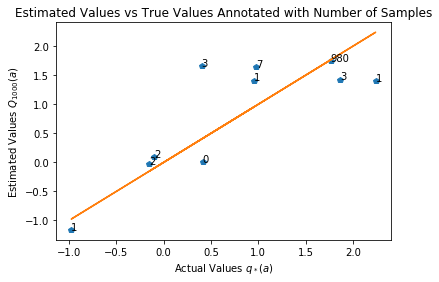

In [230]:
fig, ax = plt.subplots()

ax.plot(means, Q_estimates, 'p')
ax.plot(means, means)
plt.xlabel('Actual Values $q_*(a)$')
plt.ylabel('Estimated Values $Q_{1000}(a)$')
plt.title("Estimated Values vs True Values Annotated with Number of Samples")

for index, number in enumerate(counters):        
        ax.annotate(int(number), (means[index], Q_estimates[index]))

In [236]:
means, variances = generate_instance(seed=0)
total_reward, avg_reward_ts, Q_estimates, means, variances = run_experiment_incremental(means, 
                                                                                        variances, 
                                                                                        time_steps=1000, 
                                                                                        epsilon=1e-2,
                                                                                        seed=0)

In [237]:
print(means)
print(variances)

[ 1.76405235  0.40015721  0.97873798  2.2408932   1.86755799 -0.97727788
  0.95008842 -0.15135721 -0.10321885  0.4105985 ]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


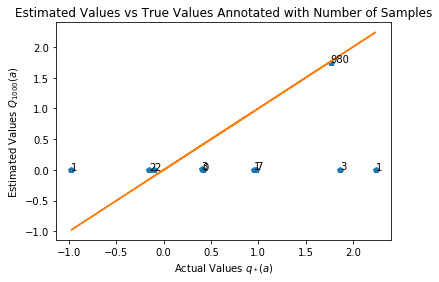

In [232]:
fig, ax = plt.subplots()

ax.plot(means, Q_estimates, 'p')
ax.plot(means, means)
plt.xlabel('Actual Values $q_*(a)$')
plt.ylabel('Estimated Values $Q_{1000}(a)$')
plt.title("Estimated Values vs True Values Annotated with Number of Samples")

for index, number in enumerate(counters):        
        ax.annotate(int(number), (means[index], Q_estimates[index]))

### Generalizations

At this stage, we can think of generalizing the problem. We made a few assumptions which can each be relaxed.

**Assumption 1**: The reward distributions are stationary i.e. the probability distribution that each action/lever samples is constant in time. This is generally not true in the real world.

**Assumption 2**: Each action taken is completely independent of the other one. In other words, there are no ***dynamics***. The act of taking action $i$ vs action $j$ at time $t$ has no effect on the slot machine itself. This is generally also not true in the real world. A person or a robot has to change their strategy completely if they are walking normally vs if they slip on a certain step. What is done next is highly dependent on the fact that you slipped or didn't slip on the previous step.  One could account for this in our problem by saying that the act of taking a particular action ***changes*** the probability distributions of all other actions which leads to non-stationary distributions too.

What would go wrong in our strategy of estimating action values by running averages if the distributions were not stationary? It's easiest to demonstrate with an example. Suppose, we have numbers coming from a uniform random distribution $\mathcal{U}[0,1]$. This means we pick numbers between 0 and 1 with equal weight given to every number (technically, the real numbers are uncountable so one can't assign a probability to picking a number, say 0.3182. Instead, a uniform distribution means that probability of picking a number between $x$ and $y$ is proportional to $|x-y|$ i.e. the length of the interval as long as $x,y\in[0,1]$).

Now suppose the the interval shifts to the right at a constant speed. In other words, at time t, we are sampling uniformly from the interval $[t, t+1]$. 

At any given time, the mean should be the mid-point $\frac{t + t+1}{2} = t + \frac{1}{2}$. But if we just take all the numbers we recorded till time t, we'll get a misleading answer.

At time $t=0$: sampled number is between 0 and 1, say 0.3.

At time $t=1$: sampled number is between 1 and 2, say 1.7.

At time $t=2$: sampled number is between 2 and 3, say 2.1.

So even though, at time $t=3$, we would expect the mean of the last 3 numbers to be somewhere reasonably close to the mean $3.5$, in actuality, we measured numbers completely below this range which would skew the average to:

$$\frac{0.3 + 1.7 + 2.1}{3} = 1.366$$

which is completely outside the interval $[3,4]$ at $t=3$!!!!!!

The problem is that our past measurements are from completely different distributions because the distribution has been moving in time.

How do we deal with this issue? There's an obvious solution. Weight recent measurements more in the running average than past measurements. Instead of the running average being:

$$\frac{x_1 + x_2 + \ldots + x_n}{n}$$

it would be:

$$\frac{w_1 x_1 + w_2 x_2 + \ldots + w_n x_n}{\Sigma_{t} w_t}$$

where $w_t$ are positive numbers that denote weights. We expect $w_t$ to monotonically increase in time to give more weight to measurements at later times t. In the special case, $w_t = 1, \forall t$, we get back our usual definition of the unweighted average.

So the big question is how should we weigh new updates so that we are biased towards more recent measurements. Recall our update equation for $Q_t(a)$:

$$Q_{t+1}(a) = Q_{t}(a) + \underbrace{\frac{1}{t}}_{\text{update weight}} [R_t - Q_t(a)]$$

In this case, as time goes on, the update weight $\frac{1}{t}$ decreases over time which has the effect that each reward value is weighted equally in the running average:

$$\frac{R_1 + R_2 + \ldots R_t}{t}$$

If we were to increase $\frac{1}{t}$, we'll hopefully get to a situation:

$$\frac{R_1 + R_2 + \ldots R_t}{t} \rightarrow \frac{w_1 R_1 + w_2 R_2 + \ldots w_t R_t}{t}$$

where $w_t$ increases with $t$.

We could pick the update weight to be anything of the form $t^p$ where $p$ is a power. Currently we have $p=-1$. The next higher we could go is $p=0$ i.e. $t^0 = 1$. So maybe we could try a constant (instead of just 1), $\alpha$.

$$Q_{t+1}(a) \stackrel{?}{=} Q_{t}(a) + \underbrace{\alpha}_{\text{try this?}} [R_t - Q_t(a)]$$

Let's see what the consequences of this are by unpacking this equation. First note:

$$Q_{t+1}(a) = Q_t(a) + \alpha [R_t - Q_t(a)] \implies Q_{t+1}(a) = \alpha R_t + (1-\alpha) Q_t(a)$$

\begin{equation}
\begin{split}
Q_{t+1}(a) &= \alpha R_t + (1 - \alpha) Q_t(a)\\
&= \alpha R_t + (1 - \alpha) [\alpha R_{t-1} + (1 - \alpha) Q_{t-1}(a)] \\
&= \alpha R_t + (1-\alpha)\alpha R_{t-1} + (1-\alpha)^2 Q_{t-1}(a) \\
&= \alpha R_t + (1-\alpha)\alpha R_{t-1} + (1-\alpha)^2 [\alpha R_{t-2} + (1 - \alpha) Q_{t-2}(a)] \\
&= \alpha R_t + (1-\alpha)\alpha R_{t-1} + (1-\alpha)^2 \alpha R_{t-2} + (1-\alpha)^3 Q_{t-2}(a)\\
&= \alpha R_t + (1-\alpha)\alpha R_{t-1} + (1-\alpha)^2 \alpha R_{t-2} + \ldots + (1-\alpha)^{t-1} \alpha R_{t-(t-1)} + (1-\alpha)^{t} \underbrace{Q_{1}(a)}_{R_1}\\
\end{split}
\end{equation}

We can see a pattern forming. The most recent reward $R_t$ has a weight of $\alpha$, the next more recent has a weight of $(1-\alpha)\alpha$ and every subsequent reward is multiplied by another factor of $1-\alpha$. If we select $\alpha \in [0,1]$, we'll get a suppression of reward earlier in time with $R_{t-k}$ getting suppressed by $\alpha (1-\alpha)^k$

This is often called exponential suppression since for small $\alpha$, $1-\alpha \approx e^{-\alpha}$ (look at the first order Taylor expansion) to give:

$Q_{t+1}(a) \approx \alpha R_t + \alpha e^{-\alpha} R_{t-1} + \ldots + \alpha e^{-k\alpha} R_{t-k} + \ldots + \alpha e^{-(t-1)\alpha} R_1 + e^{-t\alpha} R_1$.

By the way, at this point, you should worry about the weights being normalized i.e. adding to 1. Otherwise we have a weighted sum, not a weighted average. Let's quickly confirm this:

\begin{equation}
\begin{split}
\alpha + \alpha (1-\alpha) + \alpha (1-\alpha)^2 + \ldots + \alpha (1-\alpha)^{t-1} + (1-\alpha)^t &= \alpha [1 +  (1-\alpha) + (1-\alpha)^2 + \ldots + (1-\alpha)^{t-1}] + (1 - \alpha)^t \\
&= \alpha \frac{(1-\alpha)^t-1}{1-\alpha-1} + (1-\alpha)^t
&= 1
\end{split}
\end{equation}


### Application to OpenGym Env

#### CartPole Environment

The goal in the cartpole environment is to balance the pole and keep it vertical as long as possible. More precisely, we have a cart that can move left/right on a frictionless track. There's an upside-down pole that is balanced at the beginning. The state of the setup can be described by 4 numbers at any given point in time:

Position of Cart: -2.4 to 2.4

Velocity of Cart: -Inf to Inf

Pole Angle: -41.8 deg to 41.8 deg

Pole Velocity at Tip: -Inf to Inf

[Reference Link for Environment]("https://github.com/openai/gym/wiki/CartPole-v0">)

We can take one of two actions:

0: Push cart to left
1: Push cart to right

For every time-step that the game is active, we get a reward of +1. Our task is to maximize this reward.

The trial terminates when:

1. The pole angle is greater than 12 deg in either direction.

2. Cart reaches the edge of the display.

3. Time-steps exceeds 200 steps.

#### k-armed Bandits

We would expect k-armed bandits to be a very poor fit for this problem but let's try anyway.

Instead of k-actions, now we have two actions - go left or go right. But, we have a much bigger problem. Instead of just one environment i.e. one set of means and variances for each action/lever, we have one such experiment for ***every possible value in the state space***. In addition, depending on the action we take at time $t$, we end up in a different experiment.


In [ ]:
#run N steps
env = gym.make('CartPole-v1')

state = env.reset()
N = 1000 #run 1000 time-steps
for t in range(N):
    env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    
    if done:
        state = env.reset()        

### Application to netpipe data

Let's first try a very simple implementation of contextual bandits. In the multi-armed bandit approach above, each arm had fixed reward distributions. Even when we discussed the non-stationary case, the assumption is that the distribution is changing slowly enough.

What if we were randomly put in front of different slot machines, each with k-arms with different underlying parameters for the reward distribution. If we know which machine we are in front of, this problem is context the **contextual multi-arm bandit problem*** or just **contextual bandits**. 

In the netpipe experiment, if the message size was fixed, we would have a multi-armed bandit problem where we choose between 1 of k discrete RX_DELAY values. The task then is to try out different RX_DELAYS (pull different levers) and follow the algorithm above to find the optimal RX_DELAY for THAT PARTICULAR message value.

Since we can have many different message values, we can treat each message value as its own experiment. In the language of data-structures, we have a dictionary of dictionaries. The first dictionary uses the message size as the key and the second dictionary uses the RX_DELAY as a key.

In [242]:
df = pd.read_csv('../data/netpipe.log')

In [243]:
df.head()

,MSG,RXD,DTXMXSZRQ,WTHRESH,PTHRESH,HTHRESH,TPUT
0,61535,6,610,10,30,16,3639.59
1,15571,57,3275,18,22,36,1087.24
2,54051,52,3212,1,39,11,2874.62
3,37847,50,2021,21,19,31,2237.28
4,6288,6,695,34,6,26,744.12


#### Step 1: We don't have access to the real netpipe environment in this notebook. So we'll simulate it by sampling from the dataframe df.

In other words, for each MSG (message size), we get (a) either sample from TPUT values (this is the reward) by choosing one of the available RXD (actions) or (b) infer a distribution with the sample mean and variance and sample from the distribution.

Text(0.5, 1.0, 'Different slopes signifiy different granularities of sampling in different ranges')

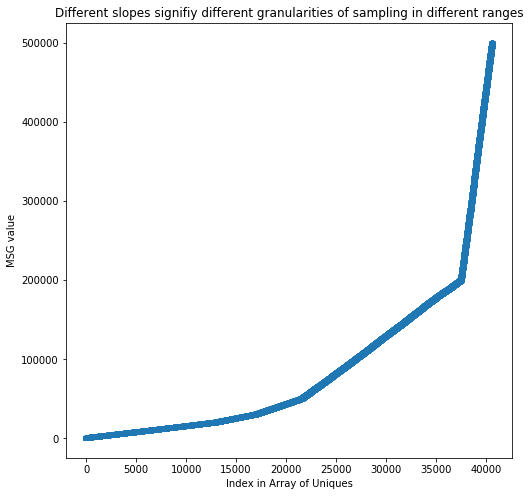

In [251]:
plt.figure(figsize=(8,8))
plt.plot(np.sort(df.MSG.unique()),'p')
plt.xlabel('Index in Array of Uniques')
plt.ylabel('MSG value')
plt.title('Different slopes signifiy different granularities of sampling in different ranges')

In [257]:
df.groupby('MSG').count().max()

# First problem: have at most 8 values for any given MSG (context)
# Solution: Let's bin the MSG values by percentiles

RXD          8
DTXMXSZRQ    8
WTHRESH      8
PTHRESH      8
HTHRESH      8
TPUT         8
dtype: int64

##### Mapping MSG -> Index in percentiles

In [326]:
percentiles = np.percentile(df.MSG, np.arange(0, 100, 5))
print(percentiles)

[   501.    2836.7   5182.4   7471.1   9779.   12254.   14688.4  17136.9
  19620.2  24143.   29203.   38188.   47775.6  67427.2  89869.4 112952.
 136439.2 159970.  183040.  250595.3]


In [327]:
def find_percentile_index(value, percentiles):
    if value < percentiles[0]:
        return -1
    if value > percentiles[-1]:
        return len(percentiles)-1
    
    return np.where(np.histogram([value], bins=percentiles)[0]==1)[0][0]

In [328]:
print(find_percentile_index(500, percentiles))
print(find_percentile_index(2840, percentiles))
print(find_percentile_index(250595, percentiles))
print(find_percentile_index(250596, percentiles))

-1
1
18
19


In [330]:
df['bin'] = df.MSG.apply(lambda x: find_percentile_index(x, percentiles))

In [331]:
df.head()

,MSG,RXD,DTXMXSZRQ,WTHRESH,PTHRESH,HTHRESH,TPUT,bin
0,61535,6,610,10,30,16,3639.59,12
1,15571,57,3275,18,22,36,1087.24,6
2,54051,52,3212,1,39,11,2874.62,12
3,37847,50,2021,21,19,31,2237.28,10
4,6288,6,695,34,6,26,744.12,2


In [332]:
df.groupby('bin').count()

#We essentially merged together a bunch of MSG values to create 20 environments
#where each environment is defined for 1/20th of the message sizes

,MSG,RXD,DTXMXSZRQ,WTHRESH,PTHRESH,HTHRESH,TPUT
bin,,,,,,,
0,2568,2568,2568,2568,2568,2568,2568
1,2568,2568,2568,2568,2568,2568,2568
2,2568,2568,2568,2568,2568,2568,2568
3,2565,2565,2565,2565,2565,2565,2565
4,2570,2570,2570,2570,2570,2570,2570
5,2568,2568,2568,2568,2568,2568,2568
6,2567,2567,2567,2567,2567,2567,2567
7,2568,2568,2568,2568,2568,2568,2568
8,2567,2567,2567,2567,2567,2567,2567


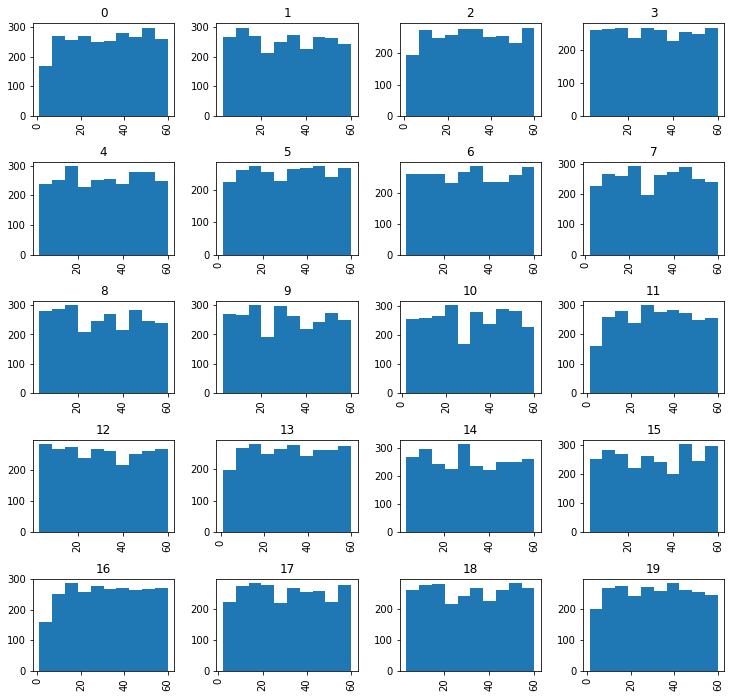

In [333]:
#some exploratory plots
df.hist(column='RXD', by='bin', figsize=(12,12));

#looking at the plots below, the distribution of arms/RXD values is pretty uniform i.e.
#we have enough statistics for each arm

(array([10.,  6.,  7.,  7.,  5.,  1.,  0.,  3.,  5.,  6.]),
 array([428.13 , 465.333, 502.536, 539.739, 576.942, 614.145, 651.348,
        688.551, 725.754, 762.957, 800.16 ]),
 <a list of 10 Patch objects>)

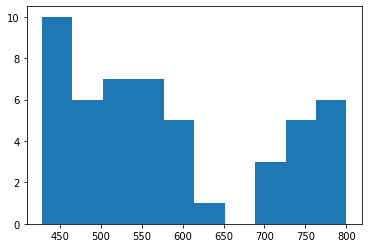

In [334]:
#reward distribution
plt.hist(df[(df.bin==1) & (df.RXD==40)].TPUT)

Let's spend some time discussing what was done above? I'll use the column names in the dataframe below.

MSG -> Message size

RXD -> Time delay

TPUT -> Throughput

Ignore the rest for now

For the netpipe experiment, we want to learn what the appropriate RXD value is for a given MSG. In particular, the exploratory plots (not in this notebook) show that there are RXD values that maximize TPUT (throughput) or power efficiency for a fixed MSG. The k-armed bandits way of phrasing this problem is the following:

* Fix a message size

* There are k-arms - one for each possible RXD

* When we pull on an arm i.e. we select a RXD, we get a certain reward (TPUT, power efficiency)

* The reward is stochastic (many other factors are not in our control) and our task is to find the RXD with the maximum expected value of reward (maximum mean).

* We can follow the learning algorithm for k-armed bandits above.

* But we don't have just one message size.

* We can treat this problem as one k-armed bandit problem for each message size.

* In real-life, we would implement the learning algorithm and let the experiment run. But we don't have the experiment in this notebook and we also want to use the already collected data.

* We can reconstruct the experimental setup by calculating the properties of the distribution of the rewards for each (MSG, RXD) pair. As one would expect, this leads to a loss of statistics i.e. each such pair has very few measurements giving us very noisy and unusable reward values.

* To fix this, we group together consecutive MSG values into one bucket where we define each bucket to be the 5% percentiles. This might be increased (7-10%) to increase the statistics but still maintain a fine granularity in MSG. We could also have combined RXD values but let's not do that for now.

In [335]:
df.RXD.unique()

array([ 6, 57, 52, 50, 58,  5, 45, 37, 22,  4, 51, 36, 46, 14, 55, 38, 20,
       41, 49, 29, 33, 18, 11, 54, 17, 31, 13, 44, 12, 47, 30,  7, 40, 48,
       10, 59, 39,  8, 26, 32, 27, 15, 35,  3, 34, 53, 24, 19, 21,  9, 28,
       42, 60, 23, 43, 25, 56, 16,  2,  1])

In [337]:
np.sort(df.RXD.unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60])

In [347]:
def netpipe_bandits(df, epsilon=1e-1, seed=None):
    '''Given an instance of the k-armed bandit problem,
    run time_steps time steps with epsilon-greedy actions.
    Update Q (value of an action) at each time-step
    '''
    
    #seed=None -> change state
    np.random.seed(seed)
    
    #dictionaries mapping bins -> lists
    Q_estimates = {}
    sums = {}
    counters = {}
    
    bin_list = df.bin.unique()
    
    #data
    bin_values = df.bin
    rxd_values = df.RXD
    tput_values = df.TPUT
    
    N_time_steps = len(bin_values)
    
    #number of arms
    unique_arms = np.sort(df.RXD.unique())
    K = len(df.RXD.unique()) #should discretize arms    

    #initialize lists
    for bin_val in bin_list:
        Q_estimates[bin_val] = np.zeros(K)
        sums[bin_val] = np.zeros(K)
        counters[bin_val] = np.zeros(K)
            
    total_reward = 0
    average_reward_timeseries = []
    
    #Start experiment
    for t in range(N_time_steps): #loop over df
        bin_val = bin_values[t]
    
        if np.random.random() < epsilon:
            #random selection
            arm_index_selected = np.random.randint(K)
        
        else:
            #greedy selection
            arm_index_selected = np.argmax(Q_estimates[bin_val])
        
        arm_selected = unique_arms[arm_index_selected]
        
        #get reward - empirical sampling
        print(f'Bin = {bin_val}')
        print(f'Rxd = {arm_selected}')
        print(df[(df.bin==bin_val) & (df.RXD==arm_selected)].shape)
        reward = np.random.choice(df[(df.bin==bin_val) & (df.RXD==arm_selected)].TPUT)
        #note: this step above will be realllly slow -> replace df by np.array
        
        total_reward += reward
        average_reward_timeseries.append(total_reward / (t+1))
        
        #update Q
        sums[bin_val][arm_index_selected] += reward
        counters[bin_val][arm_index_selected] += 1
        
        Q_estimates[bin_val][arm_index_selected] = sums[bin_val][arm_index_selected] / counters[bin_val][arm_index_selected]

    #assert(np.allclose(np.sum(sums), total_reward, rtol=1e-5)) #comparison within tolerance rtol
    
    return total_reward, average_reward_timeseries, Q_estimates, sums, counters

In [348]:
total_reward, average_reward_ts, Q_estimates, sums, counters = netpipe_bandits(df)

Bin = 12
Rxd = 1
(0, 8)


ValueError: 'a' cannot be empty unless no samples are taken